# Titanic Data Analysis

Authors: $\lambda$ Justin Ventura & Blaine Mason $\lambda$

Date: Tuesday, December 1st, 2020.

## - Description -

In this notebook, we will use various machine learning techniques in order to create a model that can predict whether a given individual on the Titanic had survived, given their 'features.'  We will show the effectiveness and learning curves of each algorithm, as well as analyze why or why not the algorithm is performing as intended.

**Below we will need to import these libraries:**

In [14]:
""" Basic Data-Science / Machine Learning Libraries: """
import re  # This is for regex filters.
import importlib  # For module loading.
import numpy as np  # Typical numpy as np.
import pandas as pd  # Dataframes library.
import seaborn as sn  # Another usefull lib.
import numpy.linalg as la  # Linear Alg np.
import matplotlib.pyplot as plt  # Plotting.
from scipy import stats  # For simple stats.
from timeit import default_timer as timer # start = timer(), end = timer()

""" K-Nearest Neighbors Model Imports """
from KNN_Model import knn_vector, kNN_Model
kvect, kmodel = knn_vector, kNN_Model

""" Import tools for Data Management """
import data_management as manager # Just import them all.
importlib.reload(manager)

""" Import and clean the Titanic Dataset """
titanic = pd.read_csv('titanic_data.csv')  # Reads data nicely.
titanic.replace({'age': {'?': np.nan}}, regex=False, inplace=True)
titanic.replace({'fare': {'?': np.nan}}, regex=False, inplace=True)
titanic[['age', 'fare']] = titanic[['age', 'fare']].astype(float)
print('(Row, Col) of Titanic Data =', titanic.shape)
titanic.head(5) # Print the first 5 entries.

(Row, Col) of Titanic Data = (1309, 14)


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


## Explanation of the data being analyzed.


The data at hand is real data collected from the Titanic (April 14-15, 1912).  Each row is a specific person who was present at the time of the ships departure.  The columns represent the 'features' of each individual such as: their name,sex, age, fare paid, ticket number, and a few others.  The most important one which we will designate as the 'class' or 'label' of every row or 'population' will be the 'survived' column (feature).

### Designating a Label.

The purpose of a 'label' or 'class' is to be able to look at the data, and find specific sub-populations that may be related through some sort of metric to define such a relationship.  In this case, the most obvious and interesting feature to be considered the label of each person is: whether or not they survived the tragic sinking of the Titanic in 1912.  This clearly gives two groups: survivors (numeric label: 1) and non-survivors (0).  Given such labels, we can then take their features and possibly find out if any given value(s) for a feature, pair of features, or any combination of certain features, could have influenced their likelihood of survival.

### Why?

There are many questions to be asked, and (almost) just as many answers to be returned.  A question one may have is: 'what does this matter?  The Titanic has already sank!'  This is true; however, some findings can be interesting to those who may be concerned as to their own likelihood of surviving a ship-wreck if they are met with these unfortunate cirumstances.  It is also interesting to see which people tended to survive, and possibly come to 'conclusions' as to why they may have been more or less likely to survive.  I use the word 'conclusion' loosely, as the #1 rule to any data analysis is: * CORRELATION DOES NOT EQUAL CAUSATION. *

### Hypothesizing Possible Correlations:

We can of course make some guesses about certain types of persons rate of survival, or make the hypthothesis: 'perhaps female passengers were most likely to survive, since they may have prioritized women and children over the men when loading the escape boats.'  There are likely some things to keep in mind; the data only separates by gender, and has no 'child' attribute, so we cannot simply do a female to male comparison.  If we consider the hypothesis, order to keep the results reliable, we will also need to filter the ages, and put those under the age of say, 18, in the same category as the women, regardless of gender.

### Correlation between Sex and Survival.

Before we check the actual rates, lets see if we can find a correlation between gender and chances of survival.  This will not take into account the 'women and children first' hypothesis, but just simply between the two genders.  We will use a heatmap on the correlation matrix between the sex and survived features.  Note that a correlation value of 1 means a perfect correlation (A goes up at rate R, B also goes up R), 0 means no correlation, and -1 means a perfect inverse correlation (A goes up at rate R, B goes down at rate R).

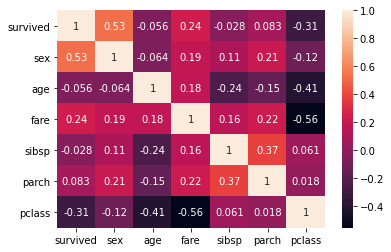

In [3]:
# Creating a subframe that shows correlations:
sex_survival = titanic[['survived', 'sex', 'age', 'fare', 'sibsp', 'parch', 'pclass']]
genders = {"male": 0, "female": 1}
sex_survival['sex'] = sex_survival['sex'].map(genders)

# Use seaborn for the heatmap then plot it:
sn.heatmap(sex_survival.corr(), annot=True)
plt.show()

### Found a Correlation!

Notice that sex and survived columns have a strong positive correlation slightly above 0.5, which indicates that as survived goes up (up to 1 means they survived), sex goes up with it (1 is for females).  This is a reasonable correlation for us to go on with testing the hypothesis.

** Now lets put that hypothesis to the test:**

Adult Men survival rate: 0.18055555555555555%
All Others survival rate: 0.6872340425531915%


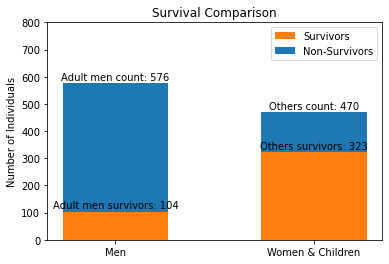

In [4]:
""" Load all the data and clean it. """
loading_boats = titanic[['survived', 'sex', 'age']]  # Sub dataset.
loading_boats = loading_boats[(loading_boats != '?').all(axis=1)]  # Clean out useless rows.
loading_boats['age'] = loading_boats['age'].astype(float)  # Make sure the ages are not str.

# Men 18+ division.
men_division = loading_boats[(loading_boats['sex'] == 'male') & (loading_boats['age'] >= 18)]
men_survive = men_division.drop(['sex'], axis=1).groupby('survived').count()

# All others.
others_division = loading_boats[(loading_boats['sex'] == 'female') | (loading_boats['age'] < 18)]
others_survive = others_division.drop(['sex'], axis=1).groupby('survived').count()

""" Visualize the data now. """
groups = (0, 0.75)  # The data has two groups: survivors, non survivors.
total_men = int(men_survive.sum())
total_other = int(others_survive.sum())
men_survived = int(men_survive[['age']].to_numpy()[1])
others_survived = int(others_survive[['age']].to_numpy()[1])
width = 0.40

# Plot the results:
totals_plot = plt.bar(groups, (total_men, total_other), width, )
survivor_plot = plt.bar(groups, (men_survived, others_survived), width)

# Numerate the total count for men.
plt.annotate(
            f'Adult men count: {total_men}',
            (0, total_men),
            xytext=(0, 1),
            textcoords="offset points",
            ha='center',
            va='bottom')

# Numerate the survivor count for men.
plt.annotate(
            f'Adult men survivors: {men_survived}',
            (0, men_survived),
            xytext=(0, 1),
            textcoords="offset points",
            ha='center',
            va='bottom')

# Numerate the total count for all others.
plt.annotate(
            f'Others count: {total_other}',
            (0.75, total_other),
            xytext=(0, 1),
            textcoords="offset points",
            ha='center',
            va='bottom')

# Numerate the survivor count for all others.
plt.annotate(
            f'Others survivors: {others_survived}',
            (0.75, others_survived),
            xytext=(0, 1),
            textcoords="offset points",
            ha='center',
            va='bottom')

# Decorate the graph.
plt.rcParams['figure.figsize'] = [12, 6]
plt.ylabel('Number of Individuals')
plt.title('Survival Comparison')
plt.xticks(groups, ('Men', 'Women & Children'))
plt.yticks(np.arange(0, 855, 100))
plt.legend((survivor_plot[0], totals_plot[0]), ('Survivors', 'Non-Survivors'))

# Log details:
print(f'Adult Men survival rate: {men_survived/total_men}%')
print(f'All Others survival rate: {others_survived/total_other}%')
pass

### Drawing a Conclusion.

Based on the evidence we have, we know there is a correlation between ones gender, and surviving the shipwreck.  We can also make a few claims as to what my have possibly *caused* the observations.  We hypothesized that perhaps the reason that men, specifically those men 18 and older, were less likely to survive due to the typical 'save the women and children first' rule.  We could also make another claim that perhaps the crew who worked on the boat (realistically most were probably men over 18) prioritized saving others over the crew.  Both of these are decent and probable claims that have some evidence to back them up, but at the end of the day we can never be 100% sure.

## Can We Describe the 'Most Likely' Person to Survive?

In [15]:
# TODO: use kNN.

titanic_copy = manager.titanic_to_vector(titanic)
titanic_copy.values()

pclass has type :<class 'str'>
<class 'str'>
survived has type :<class 'str'>
do the survived
name has type :<class 'str'>
sex has type :<class 'str'>
do the sex
age has type :<class 'str'>
do the age
sibsp has type :<class 'str'>
parch has type :<class 'str'>
do the parch
ticket has type :<class 'str'>
fare has type :<class 'str'>
do the fare
cabin has type :<class 'str'>
embarked has type :<class 'str'>
do the embarked
boat has type :<class 'str'>
body has type :<class 'str'>
home.dest has type :<class 'str'>


AttributeError: 'NoneType' object has no attribute 'values'

In [6]:
# TODO: Make a Neural Network.